In [50]:
import pandas as pd
import re
from sentence_transformers import SentenceTransformer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [51]:
df = pd.read_excel("../data/review_taman-kota.xlsx")

In [52]:
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4908 entries, 0 to 4907
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review_id       4908 non-null   object
 1   rating          4908 non-null   int64 
 2   date            4908 non-null   object
 3   review_text     4894 non-null   object
 4   date_parsed     4908 non-null   object
 5   year            4908 non-null   int64 
 6   has_review      4908 non-null   bool  
 7   clean_review    4838 non-null   object
 8   sentiment_type  4908 non-null   object
dtypes: bool(1), int64(2), object(6)
memory usage: 311.7+ KB


In [53]:
df_neg = df[df['sentiment_type'] == 'negative'].copy()

In [54]:
from langdetect import detect

def detect_lang(text):
    try:
        return detect(text)
    except:
        return "unknown"

df_neg["lang"] = df_neg["clean_review"].astype(str).apply(detect_lang)


In [55]:
df_neg.loc[df_neg["lang"] != "id",'clean_review'].iloc[0]

'good place tapi hangout with family friend orang relatives but some place need a police tapi warn the couple who doesnt remember when they are ini the park'

In [56]:
df_new = (
    df_neg
    .loc[df_neg["lang"] != "en"]
    .copy()
    .reset_index(drop=True)
)


In [57]:
df = pd.read_csv("../data/colloquial-indonesian-lexicon.csv")

# Ubah jadi dictionary: {"slang": "formal"}
custom_slang = dict(zip(df['slang'], df['formal']))

#Fungsi normalisasi slang
def normalize_slang(text):
    words = text.split()
    normalized = [custom_slang.get(w.lower(), w) for w in words]
    
    return " ".join(normalized)

In [58]:
def normalize_domain(text):
    domain_map = {
        r'\bcar\s*free\s*day\b': 'car_free_day',
        r'\bcfd\b': 'car_free_day',

        r'\barea\s*bermain\b': 'playground',
        r'\btaman\s*bermain\b': 'playground',
        r'\bmainan\s*anak\b': 'playground',

        r'\bjoging\b': 'jogging',
        r'\bjogging\s*track\b': 'jogging',
        r'\bjalan\s*santai\b': 'jogging',
        r'\blari\b': 'jogging'
    }

    for pattern, replacement in domain_map.items():
        text = re.sub(pattern, replacement, text)

    return text


In [59]:
with open("../data/combined_stop_words.txt", "r", encoding="utf-8") as f:
    custom_stopwords = f.read().splitlines()

In [60]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Stopwords Sastrawi
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()

# Stemmer & Stopword
stemmer = StemmerFactory().create_stemmer()

# Tambahkan stopwords custom
general_words={
# 'alun',
# 'lumajang',
# 'kota',
# 'taman'
# "bagus", "banget", "indah", "cukup",
#     "enak", "mantap", "oke", "lumayan"
}

stopwords.extend(custom_stopwords)
stopwords.extend(general_words)
stopwords.append("nya")

def remove_stopwords(tokens):
    return [w for w in tokens if w not in stopwords]



In [61]:
def tfidf_preprocess(text):
    text = text.lower()
    text = text.replace("-", " ")

    # remove URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # keep alphabet only
    text = re.sub(r'[^a-z\s]', ' ', text)

    # slang normalization (custom)
    text = normalize_slang(text)
    
    text = normalize_domain(text)

    tokens = text.split()
    
    PROTECTED_WORDS = {
        'santai', 'bersantai',
        # 'ramai', 'pantai',
        # 'asri', 'nyaman', 
    }

    # tokens = [t if t in PROTECTED_WORDS else stemmer.stem(t) for t in tokens ]

    # stemming (Sastrawi per token)
    # tokens = [stemmer.stem(t) for t in tokens if len(t) > 2]
    tokens = [stemmer.stem(t) for t in tokens if len(t) > 2]
    
    # stopword removal (custom, jangan hapus negasi)
    tokens = remove_stopwords(tokens)


    return " ".join(tokens)


In [62]:
df_new['clean_text'] = df_new['review_text'].apply(tfidf_preprocess)

In [63]:
# Visualisasi WordCloud
all_text = ' '.join(df_new['clean_text'].astype(str))
tokens = re.findall(r'\b\w+\b', all_text.lower())

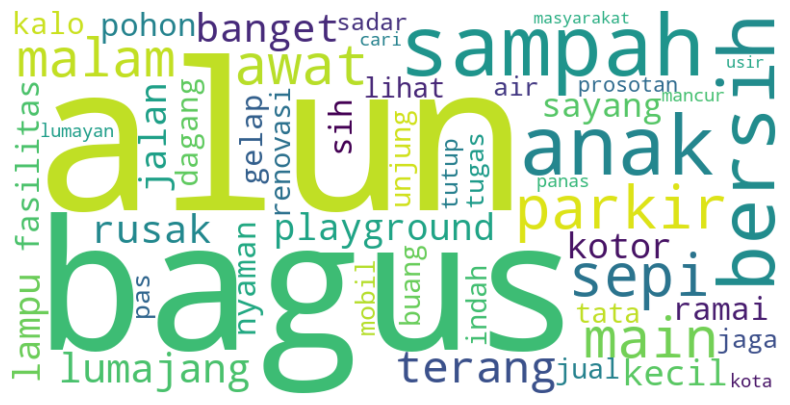

In [64]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Hitung frekuensi kata dan ambil 50 kata yang paling sering muncul
token_counts = Counter(tokens)
top_100 = token_counts.most_common(50)

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate_from_frequencies(dict(top_100))

# Menampilkan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [65]:
d

NameError: name 'd' is not defined

In [ ]:
import re
import pandas as pd
import numpy as np

from gensim import corpora, models
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

import matplotlib.pyplot as plt


In [ ]:
texts = df_new['clean_text'].str.split().tolist()


In [ ]:
bigram = Phrases(
    texts,
    min_count=5,
    threshold=10
)

bigram_mod = Phraser(bigram)

texts_bigram = [bigram_mod[t] for t in texts]


In [ ]:
dictionary = corpora.Dictionary(texts_bigram)

# filter kata terlalu jarang & terlalu umum
dictionary.filter_extremes(
    no_below=5,   # muncul minimal di 5 dokumen
    no_above=0.5 # muncul di max 50% dokumen
)

corpus = [dictionary.doc2bow(text) for text in texts_bigram]


In [ ]:
print("Jumlah dokumen:", len(corpus))
print("Jumlah vocab:", len(dictionary))


Jumlah dokumen: 328
Jumlah vocab: 53


In [ ]:
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=4,
    random_state=42,
    chunksize=100,
    passes=10,
    alpha='auto',
    eta='auto',
    per_word_topics=True
)


In [ ]:
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}:")
    print(topic)
    print("="*50)


Topic 0:
0.180*"parkir" + 0.159*"sampah" + 0.126*"kotor" + 0.082*"bersih" + 0.053*"nyaman" + 0.052*"mobil" + 0.044*"buang_sampah" + 0.039*"sadar" + 0.037*"rapi" + 0.033*"pagi"
Topic 1:
0.272*"bagus" + 0.117*"awat" + 0.051*"sih" + 0.045*"bersih" + 0.041*"indah" + 0.039*"tata" + 0.037*"dagang" + 0.033*"jual" + 0.029*"asri" + 0.028*"air_mancur"
Topic 2:
0.209*"lampu" + 0.197*"ramai" + 0.089*"pohon" + 0.059*"renovasi" + 0.056*"luas" + 0.053*"panas" + 0.053*"cari" + 0.039*"car" + 0.039*"free" + 0.034*"pas"
Topic 3:
0.189*"sepi" + 0.085*"terang" + 0.084*"banget" + 0.078*"anak" + 0.075*"malam" + 0.070*"main" + 0.050*"playground" + 0.040*"fasilitas" + 0.040*"rusak" + 0.039*"jalan"


In [ ]:
coherence_model = CoherenceModel(
    model=lda_model,
    texts=texts_bigram,
    dictionary=dictionary,
    coherence='c_v'
)

coherence_score = coherence_model.get_coherence()
print("Coherence Score:", coherence_score)


Coherence Score: 0.4661492030857377


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=10, step=1):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            alpha='auto',
            eta='auto'
        )
        model_list.append(model)

        coherence_model = CoherenceModel(
            model=model,
            texts=texts,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values


In [ ]:
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=texts_bigram,
    start=2,
    limit=11,
    step=1
)


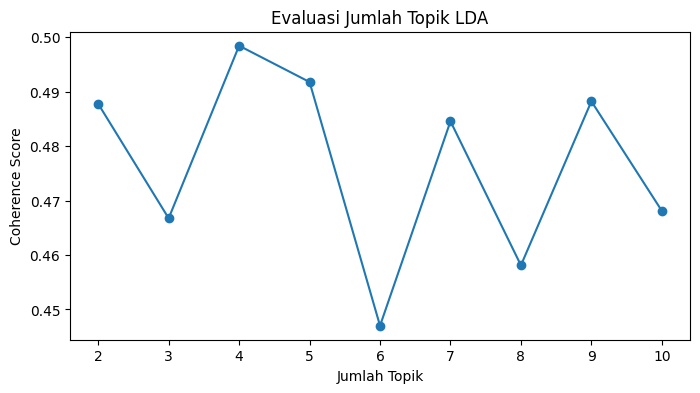

In [ ]:
x = range(2, 11)

plt.figure(figsize=(8,4))
plt.plot(x, coherence_values, marker='o')
plt.xlabel("Jumlah Topik")
plt.ylabel("Coherence Score")
plt.title("Evaluasi Jumlah Topik LDA")
plt.show()


In [ ]:
def get_dominant_topic(lda_model, corpus):
    dominant_topics = []

    for doc in corpus:
        topic_probs = lda_model.get_document_topics(doc)
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
        dominant_topics.append(dominant_topic)

    return dominant_topics

df_new['dominant_topic'] = get_dominant_topic(lda_model, corpus)


In [ ]:
for topic in sorted(df_new['dominant_topic'].unique()):
    print(f"\nTOPIC {topic}")
    print("-"*40)
    sample = df_new[df_new['dominant_topic'] == topic].iloc[0]
    print(sample['review_text'])



TOPIC 0
----------------------------------------
Kursi dan beberapa permainan perlu diberikan perawatan
Perawatan fasilitas sangat kurang terjaga
Tempat sampah banyak yg tidak ada tutupnya jadi membuat bau tidak sedap

TOPIC 1
----------------------------------------
Ini aga beda bukan diusir satpol pp tapi diusir pedagang yg jualan di trotoar yang emng ditujukan untuk masyrakat umum buat duduk tetapi diusir dengan alasan mau masang tikar untuk jualan karna satpol pp nya sudah pergi

TOPIC 2
----------------------------------------
Setiap Minggu cfd,ramai sekali,tdk nyaman untuk olahraga, terlalu padat

TOPIC 3
----------------------------------------
Di tempat bermain anak² yg prosotan tolong diperbaiki krna sdh banyak bgt semen yg RUSAK dan MENGELUPAS,bahaya wktu ank² kecil maen prosotan bisa² kulit atau bdan mreka yg luka pas maen prosotan,,tlong ya dinas² terkait terutama bpk bupati …

TOPIC 4
----------------------------------------
Ada playground, beberapa alat gym, rumah burung

In [ ]:
for idx, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {idx}:")
    print(topic)
    print("="*50)

Topic 0:
0.226*"parkir" + 0.091*"sampah" + 0.064*"mobil" + 0.063*"luas" + 0.061*"jaga" + 0.055*"buang_sampah" + 0.048*"sadar" + 0.047*"unjung" + 0.046*"tugas" + 0.043*"panas"
Topic 1:
0.285*"lampu" + 0.267*"awat" + 0.083*"dagang" + 0.075*"jual" + 0.064*"air_mancur" + 0.029*"memang" + 0.021*"jalan" + 0.012*"masyarakat" + 0.004*"perhati" + 0.004*"nyaman"
Topic 2:
0.303*"ramai" + 0.135*"pohon" + 0.081*"cari" + 0.072*"nyaman" + 0.064*"mungkin" + 0.059*"free" + 0.059*"car" + 0.044*"pas" + 0.004*"tugas" + 0.004*"panas"
Topic 3:
0.272*"sepi" + 0.121*"banget" + 0.107*"malam" + 0.083*"main" + 0.062*"sih" + 0.054*"jalan" + 0.051*"kalo" + 0.044*"anak_kecil" + 0.037*"indah" + 0.028*"gelap"
Topic 4:
0.213*"bagus" + 0.105*"bersih" + 0.079*"terang" + 0.065*"kotor" + 0.058*"anak" + 0.049*"rusak" + 0.046*"playground" + 0.046*"sampah" + 0.037*"fasilitas" + 0.037*"sayang"
